In [1]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from lmfit import minimize, Parameters, Parameter, report_fit
from numpy import asarray
from numpy import savetxt
import os
import time
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
start = time.time() #Saves the begining time of the process

from Funciones import EstimacionVariables, DifFinitas2

In [2]:
#Variables conocidas del modelo SIR

gamma = 1./21.
fechas = pd.read_csv('Fechas/' + 'Fechas.csv')
#####################################################

depas = pd.read_csv('DEPARTAMENTOS/Departamentos.csv')
NOMBREDEPTO =  depas["Departamentos"]
#####################################################

POSITIVOSDEPTO = [] 
for n in range(len(NOMBREDEPTO)):
    rep_diarios = pd.read_csv('dA/' + NOMBREDEPTO[n] + '_ReporteDiario.csv')
    c = rep_diarios["Reporte_Diario"].values.tolist()
    POSITIVOSDEPTO.append(c)
#####################################################    

acumuladosReportados = [] 
for n in range(len(NOMBREDEPTO)):
    acumulados = pd.read_csv('ACUMULADOS/' + NOMBREDEPTO[n] + '_Acumulados_Reportados.csv')
    c = acumulados["Acumulados_Reportados"].values.tolist()
    acumuladosReportados.append(c)
    
#####################################################    

Poblacion = pd.read_csv('POBLACION/' + 'Poblacion.csv')["Poblacion"].values.tolist()

In [3]:
A, dA, S, I,R, Beta, Rt, R0 = EstimacionVariables(acumuladosReportados, POSITIVOSDEPTO, Poblacion, gamma)

In [4]:
def adfuller_test(serie):
    result=adfuller(serie)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
    return result

In [5]:
adfuller_test(Beta[0][:727])

ADF Test Statistic : -3.47514904214569
p-value : 0.008648732829846273
#Lags Used : 20
Number of Observations : 706
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


(-3.47514904214569,
 0.008648732829846273,
 20,
 706,
 {'1%': -3.439646367660705,
  '5%': -2.8656425177031375,
  '10%': -2.5689546724554404},
 -7269.375504427285)

In [6]:
Beta[0][727]

0.049329006168562735

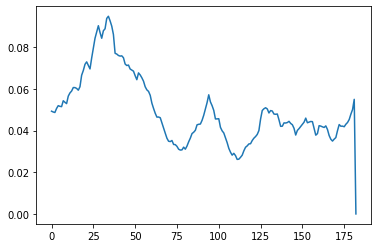

In [7]:
plt.plot(Beta[0][727:])

In [8]:
#si quiere de grado 2, aplique dos veces Diferencias con grado=1
#para quitar tendencia y periodicidad
def Diferencias(serie): #grado 1 implicito
    #suponga grado = 1
    #serie = [1,2,3,4,5]
    s1 = np.array(serie[:len(serie)-1]) #[1,2,3,4]
    s2 = np.array(serie[1:])#[2,3,4,5]
    serie_nueva = (s2-s1).tolist()
    return serie_nueva

In [9]:
#serie_nueva = Diferencias(Beta[0][:583])
serie_nueva = Diferencias(Beta[0][:727])


In [10]:
adfuller_test(serie_nueva)

ADF Test Statistic : -5.958273519987637
p-value : 2.0681548295905167e-07
#Lags Used : 20
Number of Observations : 705
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


(-5.958273519987637,
 2.0681548295905167e-07,
 20,
 705,
 {'1%': -3.4396596024765795,
  '5%': -2.86564834926679,
  '10%': -2.568957779286756},
 -7252.2404114424635)

In [11]:
#Es un proceso estacionario!
inicio = 727+25
fin = 827
t= []
for i in range(inicio, fin+1):
    t.append(i)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


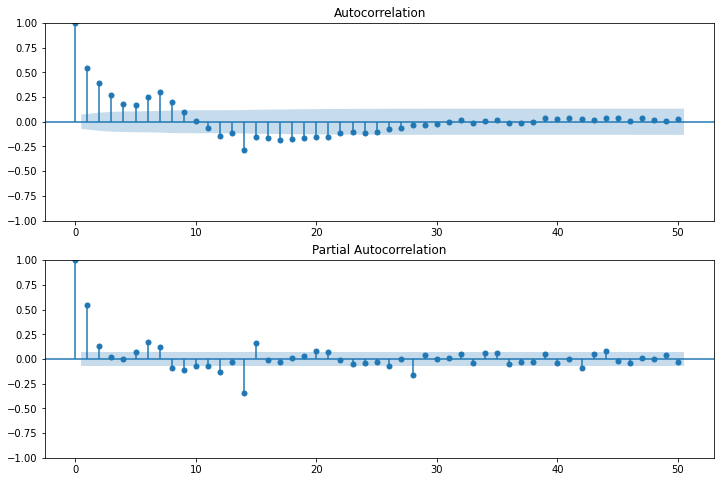

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(serie_nueva, lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(serie_nueva, lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_SerieNueva_GT_ola1.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


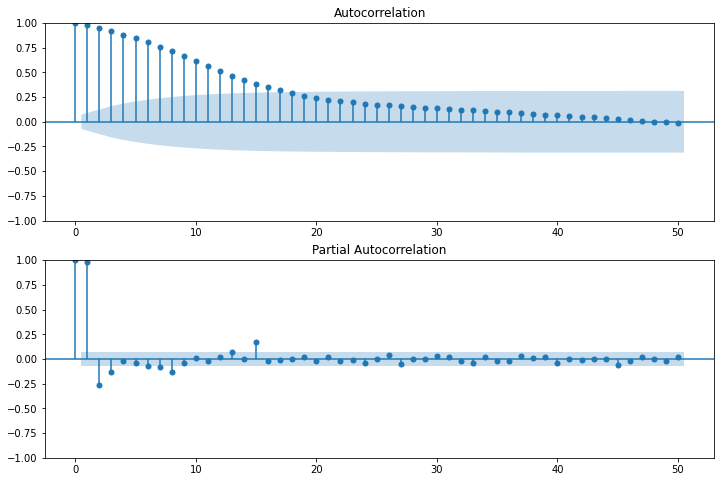

In [13]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Beta[0][:727], lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Beta[0][:727], lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_Beta_GT_ola4.pdf', bbox_inches = 'tight')


In [14]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of difference.
#q: The size of the moving average window, also called the order of moving average.

In [14]:
def ECM(x,y):
    #y es lo observado
    X = np.array(x)
    Y = np.array(y)
    Z = (X-Y)**2
    return Z.mean()

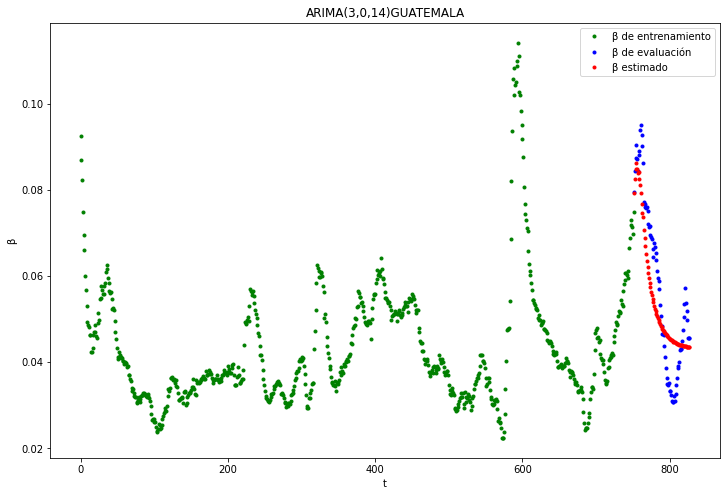

In [16]:
#suponiendo inicio=586
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=3
d=0
q = 14
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola4_sinTransformacion_a.pdf', bbox_inches = 'tight')


In [17]:
np.array(Beta[0][:727]).mean()

0.042613177832197736

In [18]:
forecast[len(forecast)-4:len(forecast)-1]

array([0.04360704, 0.04357788, 0.04355068])

In [19]:
#calcular el ECM para solo unos dias, ya que en la practica no conocemas toda la evolución de la curva
p=3
d=0
Q=[]
error = []
print("q", "ECM")
for q in range(0,20):
    model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ecm = ECM(forecast[:10], Beta[0][inicio:inicio+10])
    Q.append(q)
    error.append(ecm)
    print(q, ecm)
    


q ECM
0 0.00019765990153596596
1 0.00019370162863964865


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 0.00016567383931459138


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 0.000235208479437525
4 0.00021241970981724737
5 0.0002277010670141602
6 0.00014943332467318634
7 0.0001305517404224873
8 0.00010821973336217218
9 0.00011254248993284568
10 9.662371243955523e-05
11 0.00010370690268527184
12 0.0001069731172560505
13 0.00010003363848189715
14 5.029705077249499e-05
15 9.986659055617596e-05
16 0.00010670807475548394
17 9.391675493661513e-05
18 9.097408042625142e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19 0.00026404355648536483


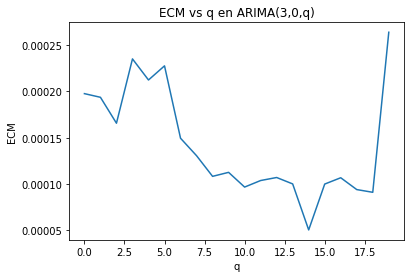

In [20]:
plt.plot(Q, error)
plt.xlabel('q')
plt.ylabel('ECM')
plt.title("ECM vs q en ARIMA(3,0,q)")
plt.savefig('Predicciones/'+'ECM_ola4.pdf', bbox_inches = 'tight')

plt.show()

In [24]:
def PorcentajeError(p, serie):
    serie = np.array(serie)
    SUP = serie + serie*p/100
    INF = serie - serie*p/100
    sup = SUP.tolist()
    inf = INF.tolist()
    return sup, inf

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


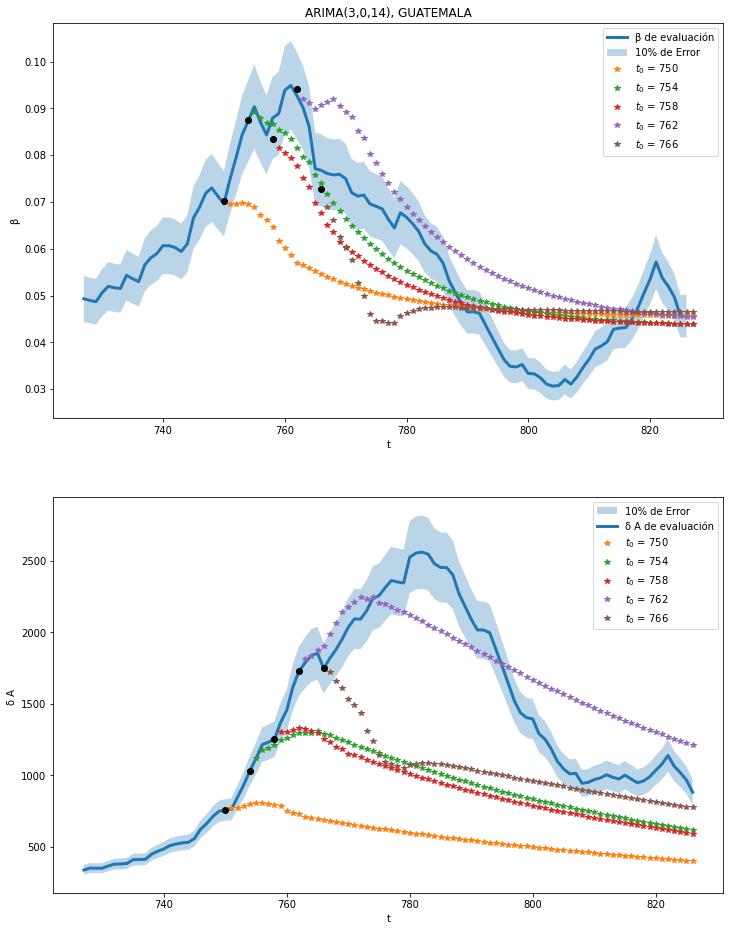

In [25]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

    

Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')


ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(750,770 ,4):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola4_ARIMA(3,0,14)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


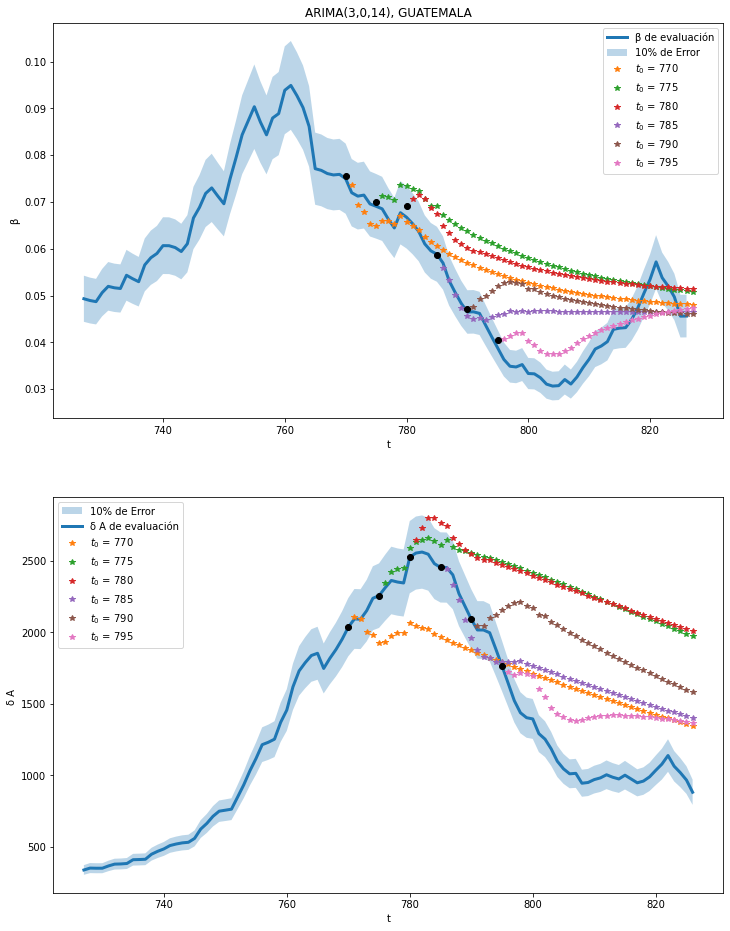

In [26]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')


ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(770, 800 ,5):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola4_ARIMA(3,0,14)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmode

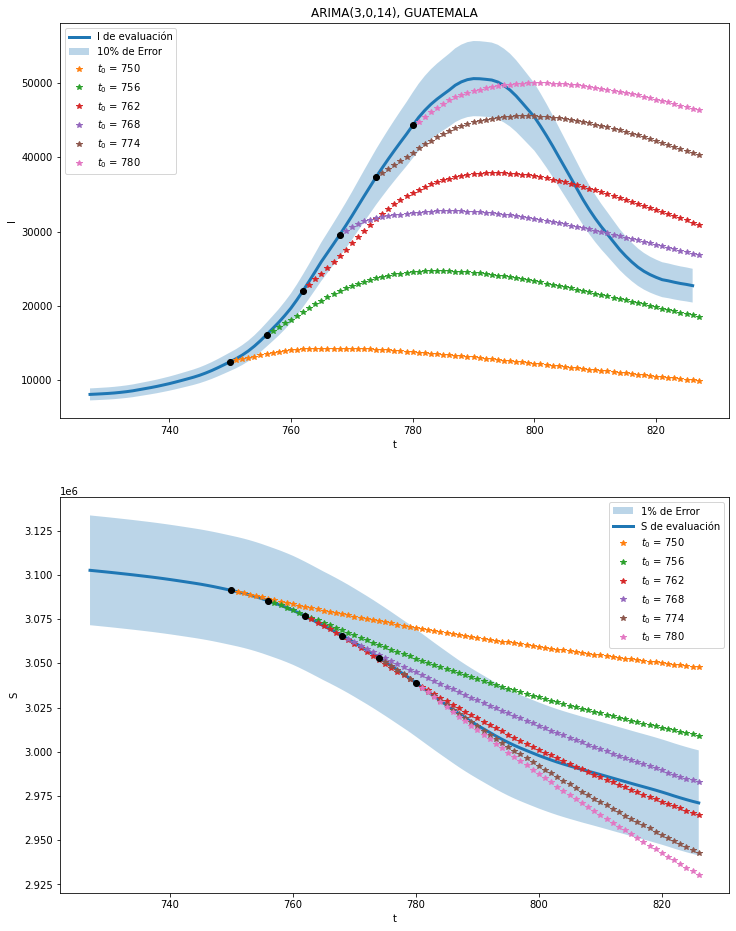

In [27]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)


I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])    
        
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])


ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')


ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(750,781 ,6):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola4_ARIMA(3,0,14)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


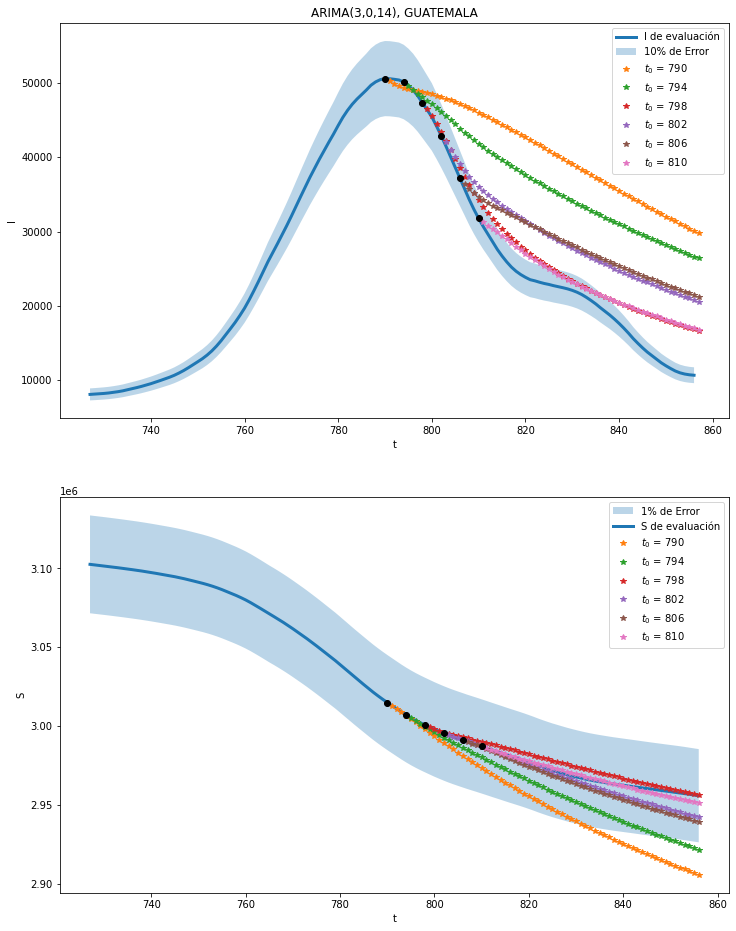

In [28]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 130
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])    
        
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])


ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')

ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(790,811 , 4):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola4_ARIMA(3,0,14)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


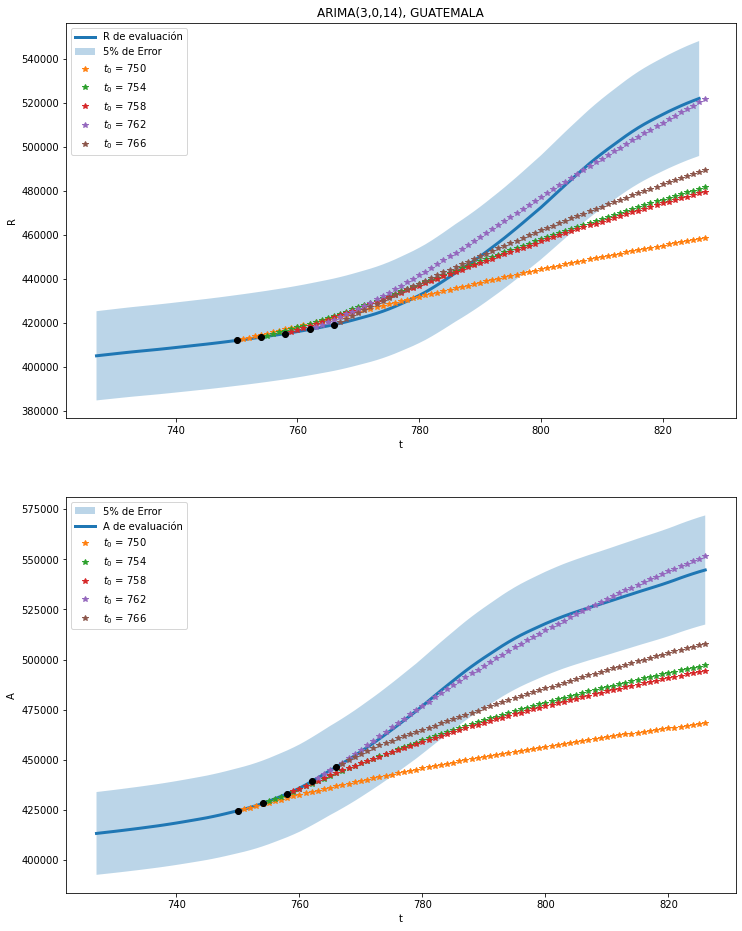

In [29]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)
R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')


ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(750,770 ,4):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola4_ARIMA(3,0,14)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


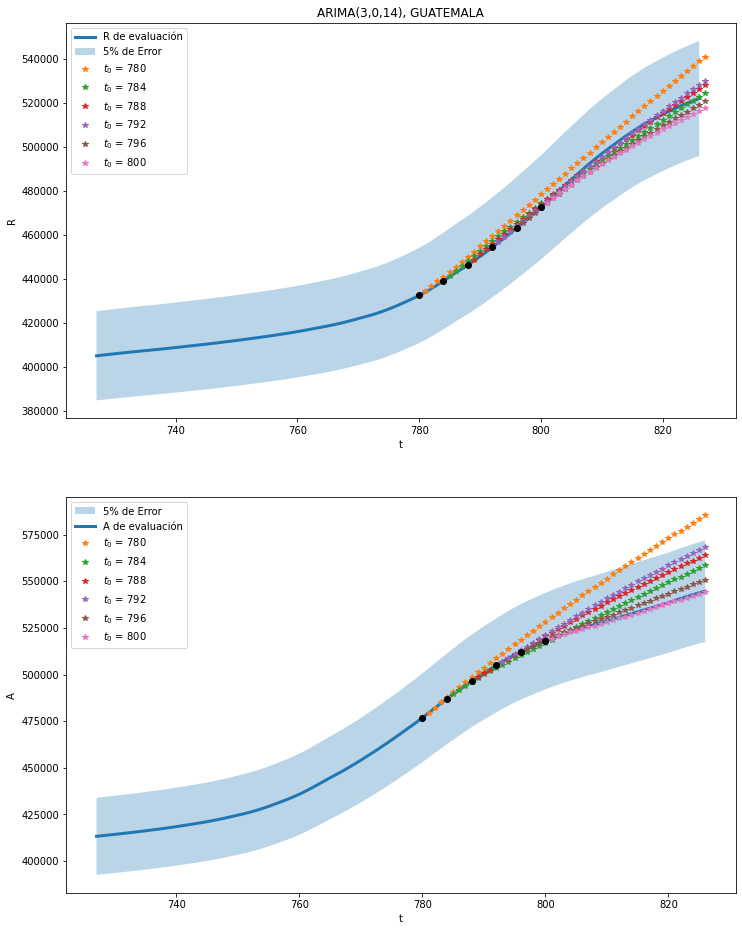

In [30]:
p=3
d=0
q=14
###################
inicio1 = 727
fin1 = 727 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')


ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(780,801, 4):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola4_ARIMA(3,0,14)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


In [31]:
fechas['Fechas'][727]

'2022-05-13'

In [15]:
model=ARIMA(Beta[0][:750],order=(3,0,14))
model_fit=model.fit()
model_fit.summary()  

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  750
Model:                ARIMA(3, 0, 14)   Log Likelihood                3873.317
Date:                Sat, 06 May 2023   AIC                          -7708.635
Time:                        12:12:35   BIC                          -7620.853
Sample:                             0   HQIC                         -7674.811
                                - 750                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0455      0.003     13.040      0.000       0.039       0.052
ar.L1          1.3740      0.228      6.016      0.000       0.926       1.822
ar.L2         -0.2282      0.157     -1.455      0.146      -0.536       0.079
ar.L3         -0.1693      0.124     -1.365      0.172      -0.412       0.074
ma.L1          0.1306      0.224      0.582      0.561      -0.309       0.570
ma.L2          0.0058      0.240      0.024      0.981      -0.465       0.476
ma.L3          0.0616      0.174      0.354      0.723      -0.279       0.402
ma.L4         -0.0158      0.148     -0.107      0.915      -0.306       0.274
ma.L5         -0.0695      0.108     -0.641      0.522      -0.282       0.143
ma.L6          0.1716      0.073      2.352      0.019       0.029       0.315
ma.L7          0.3202      0.096      3.351      0.001       0.133       0.507
ma.L8          0.1492      0.150      0.993      0.321      -0.145       0.444
ma.L9          0.0461      0.168      0.275      0.783      -0.282       0.375
ma.L10         0.0241      0.146      0.164      0.870      -0.263       0.311
ma.L11        -0.0251      0.115     -0.219      0.826      -0.250       0.200
ma.L12        -0.0808      0.088     -0.916      0.360      -0.254       0.092
ma.L13         0.1691      0.060      2.810      0.005       0.051       0.287
ma.L14        -0.3714      0.084     -4.446      0.000      -0.535      -0.208
sigma2      1.863e-06   6.91e-08     26.970      0.000    1.73e-06       2e-06
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):              1372.59
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""